**Setup (Download Kaggle dataset inside Colab)**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/global-weather-repository")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'global-weather-repository' dataset.
Path to dataset files: /kaggle/input/global-weather-repository


**Step 1 — Import Libraries & Load Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("/kaggle/input/global-weather-repository/GlobalWeatherRepository.csv")
df.head()


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


**Step 2 — Data Cleaning / Preprocessing**

In [ ]:
# Convert to datetime
df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')

# Sort by time
df = df.sort_values("last_updated")

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Basic Outlier Removal (Z-score)
from scipy.stats import zscore
# Select numeric columns before outlier removal to calculate zscore based on them
initial_numerics = df.select_dtypes(include=np.number)
df = df[(np.abs(zscore(initial_numerics)) < 4).all(axis=1)]

# Re-select numeric columns after outlier removal for scaling
numerics_for_scaling = df.select_dtypes(include=np.number)

# Normalize features
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_df[numerics_for_scaling.columns] = scaler.fit_transform(numerics_for_scaling)
scaled_df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
186,United States of America,Washington Park,0.833570,0.154365,America/Los_Angeles,0.0,2024-05-16 01:45:00,0.460912,0.460633,Clear,...,0.054241,0.023684,0.000000,0.000000,05:26 AM,08:31 PM,01:36 PM,02:52 AM,Waxing Gibbous,0.55
40,Costa Rica,San Juan,0.486202,0.257096,America/Costa_Rica,0.0,2024-05-16 02:45:00,0.540717,0.540271,Fog,...,0.190461,0.079033,0.333333,0.111111,05:15 AM,05:51 PM,12:42 PM,12:37 AM,Waxing Gibbous,0.55
17,Belize,Belmopan,0.555239,0.243863,America/Belize,0.0,2024-05-16 02:45:00,0.622150,0.622624,Overcast,...,0.066624,0.109099,0.000000,0.000000,05:23 AM,06:20 PM,12:56 PM,01:04 AM,Waxing Gibbous,0.55
124,Nicaragua,Managua,0.506875,0.250917,America/Managua,0.0,2024-05-16 02:45:00,0.641694,0.640724,Patchy rain nearby,...,0.102006,0.049650,0.000000,0.000000,05:21 AM,06:02 PM,12:49 PM,12:49 AM,Waxing Gibbous,0.55
52,El Salvador,San Salvador,0.521669,0.242650,America/El_Salvador,0.0,2024-05-16 02:45:00,0.622150,0.621719,Moderate or heavy rain with thunder,...,0.178962,0.095433,0.333333,0.111111,05:30 AM,06:16 PM,01:00 PM,01:02 AM,Waxing Gibbous,0.55


**Step 3 — Basic EDA (Visualizations)**

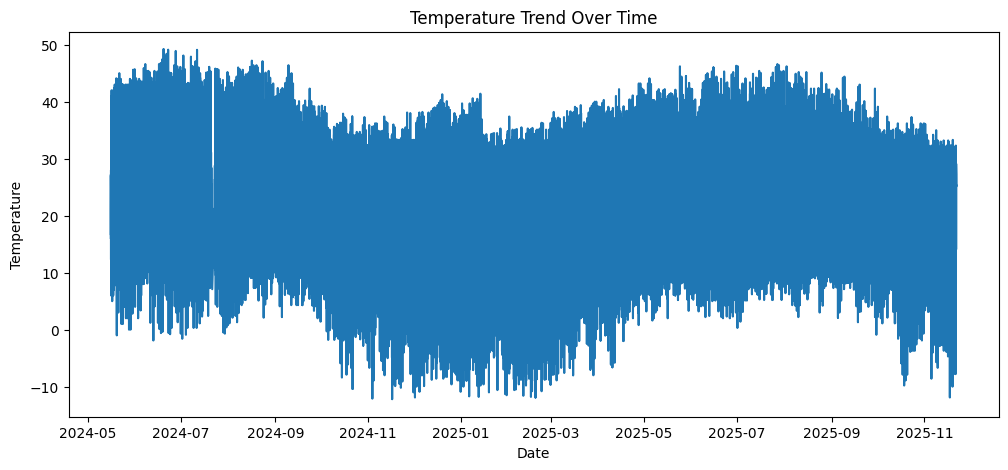

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['last_updated'], df['temperature_celsius'], label="temperature_celsius")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature Trend Over Time")
plt.show()


**Precipitation Trend**

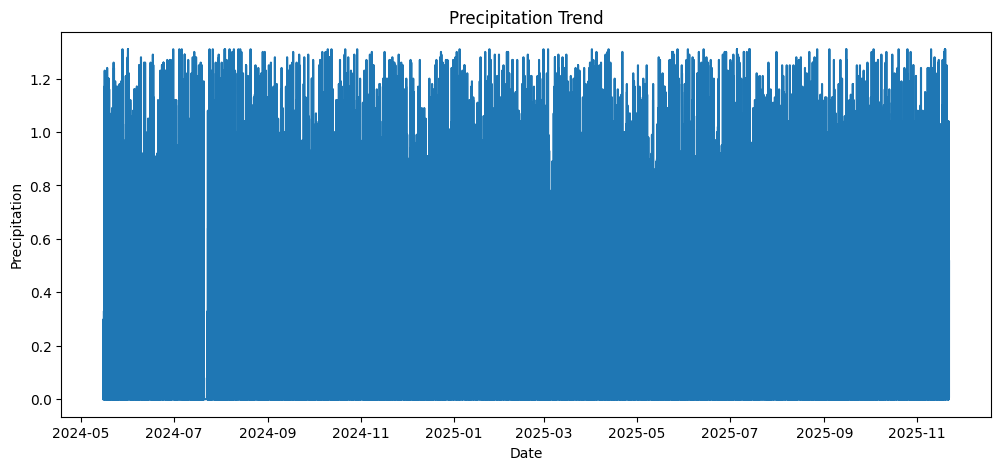

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['last_updated'], df['precip_mm'], label="Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Trend")
plt.show()


**Correlation Heatmap**

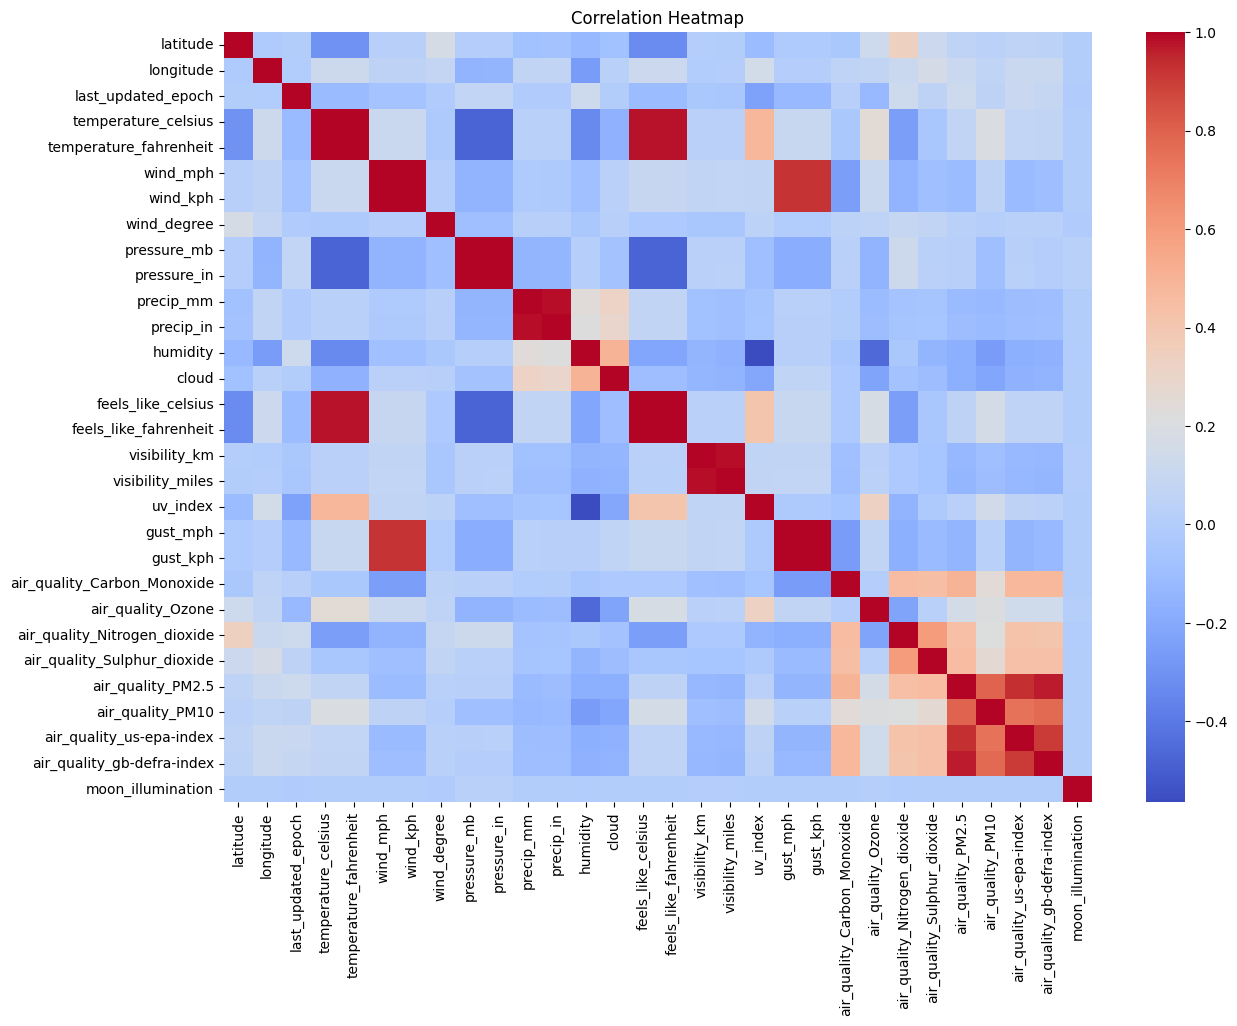

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

**Step 4 — Advanced EDA (Anomaly Detection)**

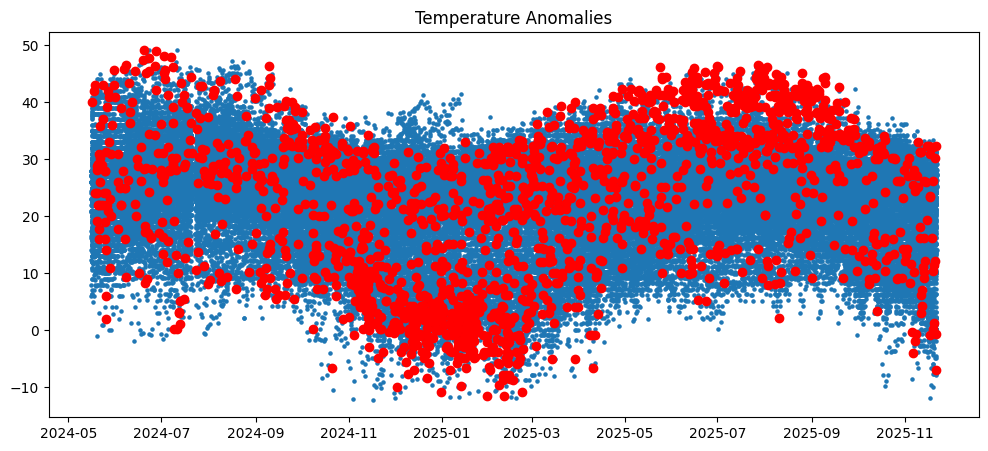

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.02)
df['anomaly'] = iso.fit_predict(numerics_for_scaling)

anomalies = df[df['anomaly'] == -1]

plt.figure(figsize=(12,5))
plt.scatter(df['last_updated'], df['temperature_celsius'], s=5)
plt.scatter(anomalies['last_updated'], anomalies['temperature_celsius'], color='red')
plt.title("Temperature Anomalies")
plt.show()


**Step 5 — Forecasting Models**

In [ ]:
city = "London"
city_df = df[df['location_name'] == city][['last_updated','temperature_celsius']].rename(columns={'last_updated':'ds','temperature_celsius':'y'})

**Model 1 — ARIMA**

In [ ]:
arima_model = ARIMA(city_df['y'], order=(5,1,2))
arima_fit = arima_model.fit()

forecast_arima = arima_fit.forecast(30)
forecast_arima


,predicted_mean
495,3.914664
496,5.965634
497,6.805914
498,7.517004
499,7.833501
500,7.793242
501,7.505195
502,7.157798
503,6.830553
504,6.572507


**Model 2 — Facebook Prophet**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 139.0 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


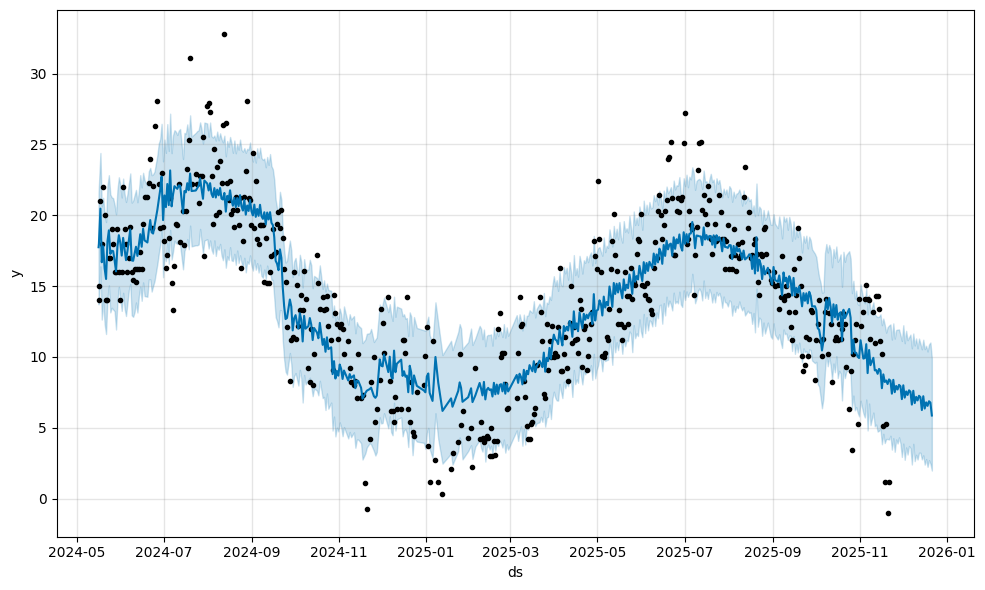

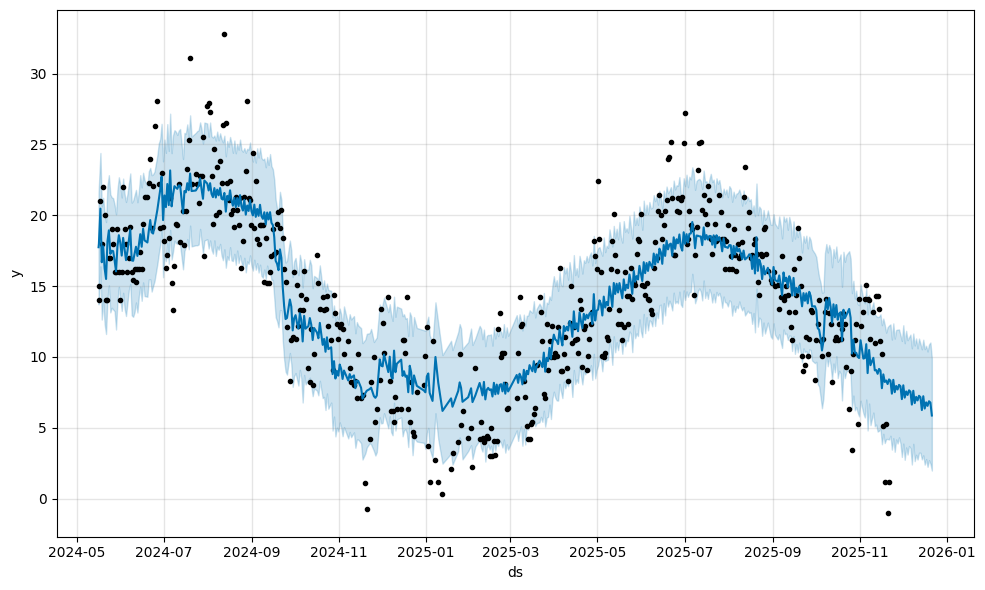

In [ ]:
!pip install --upgrade cmdstanpy
!pip install --upgrade prophet


prophet_model = Prophet()
prophet_model.fit(city_df)

future = prophet_model.make_future_dataframe(periods=30)
forecast_prophet = prophet_model.predict(future)

prophet_model.plot(forecast_prophet)


**Step 6 — Ensemble Model (Prophet + ARIMA)**

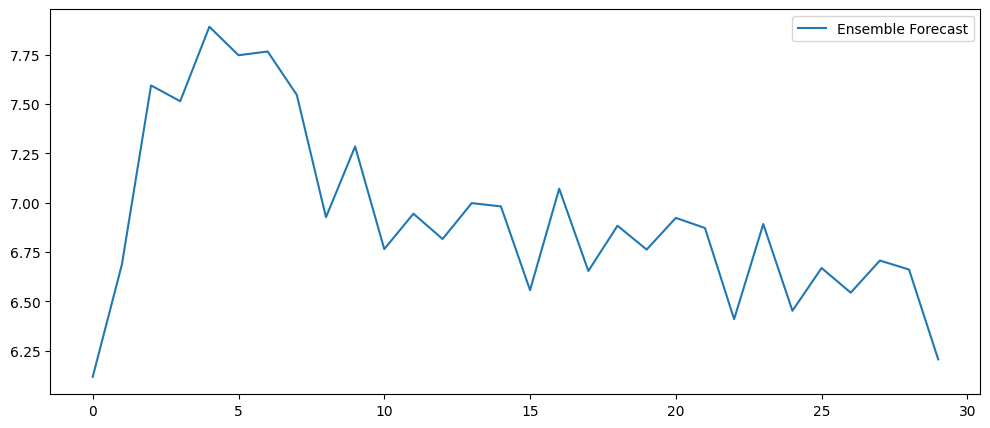

In [ ]:
ensemble = (forecast_prophet['yhat'][-30:].values + forecast_arima.values) / 2

plt.figure(figsize=(12,5))
plt.plot(ensemble, label="Ensemble Forecast")
plt.legend()
plt.show()


**Step 7 — Climate Analysis (Decadal Temp Change)**

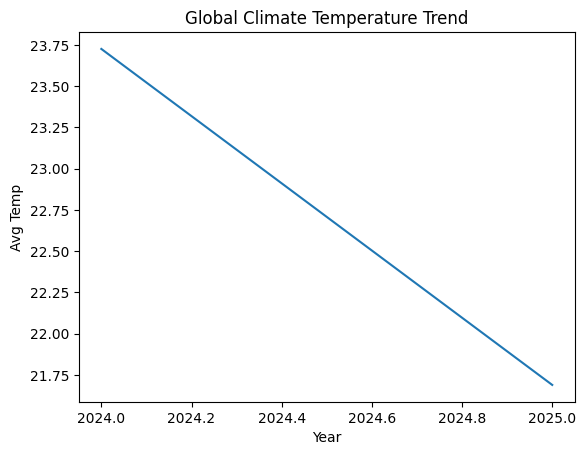

In [ ]:
df['year'] = df['last_updated'].dt.year
climate_trend = df.groupby('year')['temperature_celsius'].mean()

plt.plot(climate_trend.index, climate_trend.values)
plt.title("Global Climate Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Avg Temp")
plt.show()


**Step 8 — Environmental Impact (Air Quality Correlation)**

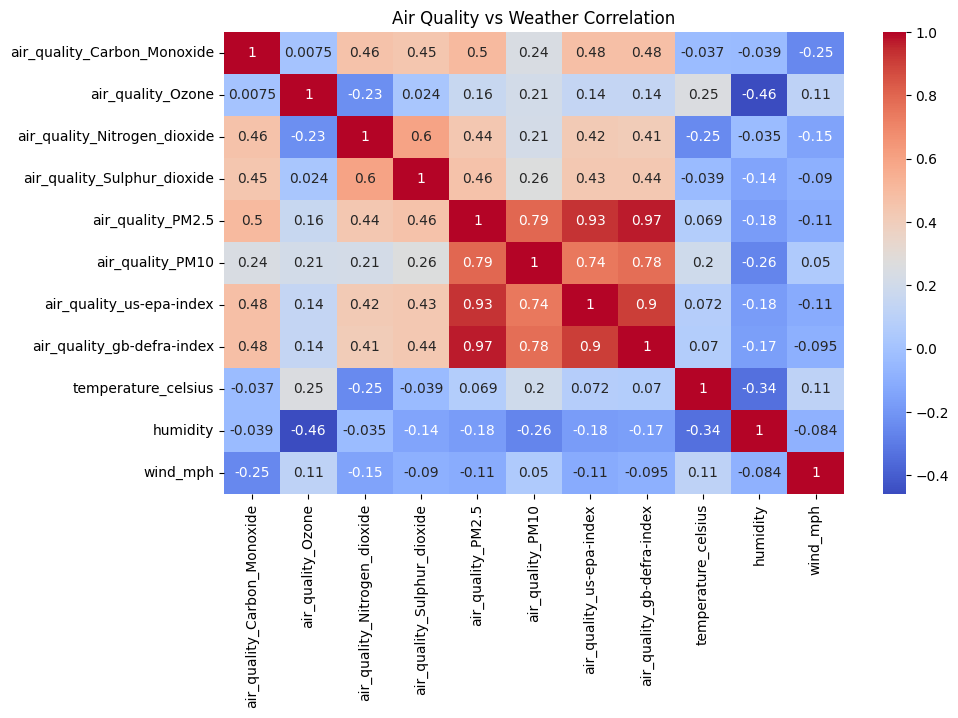

In [ ]:
aq_cols = [c for c in df.columns if "pm" in c.lower() or "air" in c.lower()]
corr = df[aq_cols + ['temperature_celsius','humidity','wind_mph']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Air Quality vs Weather Correlation")
plt.show()


**Step 9 — Feature Importance (Random Forest)**

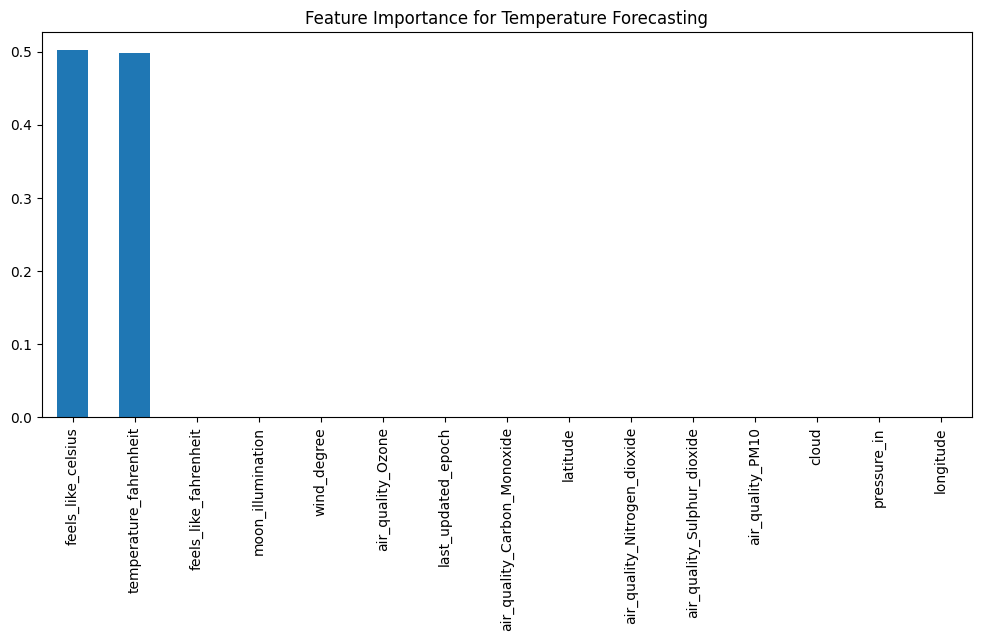

In [ ]:
features = numerics_for_scaling.drop(columns=['temperature_celsius']).columns
X = numerics_for_scaling[features]
y = numerics_for_scaling['temperature_celsius']

rf = RandomForestRegressor()
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
importances.head(15).plot(kind='bar', figsize=(12,5))
plt.title("Feature Importance for Temperature Forecasting")
plt.show()


**Step 10 — Spatial Analysis (Geographical Mapping)**

In [ ]:
geo_df = df.groupby(['country']).agg({'temperature_celsius':'mean'}).reset_index()

fig = px.choropleth(
    geo_df,
    locations="country",
    locationmode="country names",
    color="temperature_celsius",
    title="Global Temperature Map"
)
fig.show()
